# Marsquake Detection

This notebook is to detect any Marsquake occurences.

In [1]:
import numpy as np
import pandas as pd
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pywt

from matplotlib import cm
from scipy import signal
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset, z_detect

In [2]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]
cat["filename"] = cat["filename"].apply(lambda x: x[:-4])
print(len(cat))
cat.head()

2


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,arrival_time,arrival_time_rel
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005,2022-02-03T08:08:27.000000,507.0,evid0005,2022-02-03 08:08:27,507.0
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006,2022-01-02T04:35:30.000000,2130.0,evid0006,2022-01-02 04:35:30,2130.0


In [3]:
train_dir = base_dir / "data/mars/training/data/"
test_dir = base_dir / "data/mars/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))
print(train_filenames)

training data:  2
test data:  9
[WindowsPath('../data/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'), WindowsPath('../data/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed')]


In [4]:
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

# Visualize training and Test Data

In [5]:
def get_time_speed(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data

    
    return tr_times, tr_data

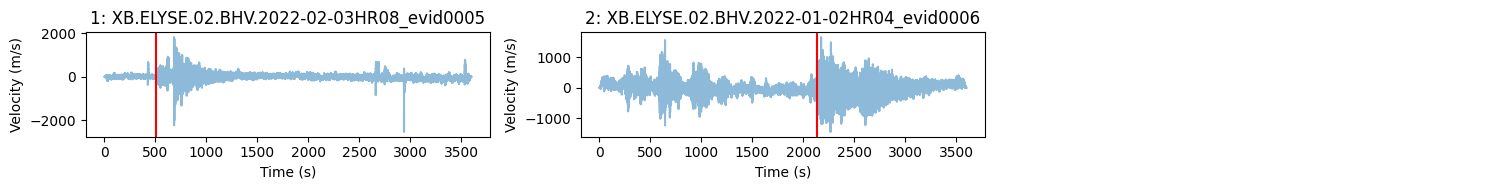

In [6]:
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)

    axs[i].plot(x, y, alpha=0.5)
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

In [7]:
def calculate_sta_lta(time_series, sta_length, lta_length):
    # Ensure input is a numpy array
    time_series = np.asarray(time_series)
    
    # Initialize STA and LTA arrays
    sta = np.zeros(len(time_series))
    lta = np.zeros(len(time_series))
    
    # Calculate STA
    for i in range(sta_length, len(time_series)):
        sta[i] = np.mean(time_series[i-sta_length:i])

    # Calculate LTA
    for i in range(lta_length, len(time_series)):
        lta[i] = np.mean(time_series[i-lta_length:i])

    # Avoid division by zero
    lta[lta == 0] = np.nan  # Set LTA to NaN where it's zero
    sta_lta_ratio = sta / lta
    
    return sta, lta, sta_lta_ratio

def sta_algo(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data

    f, t, sxx = signal.spectrogram(tr_data, trace.stats.sampling_rate)
    sta_n, lta_n, sta_by_lta = calculate_sta_lta(np.max(sxx, axis=0), 2, 100)
    return sta_n, t

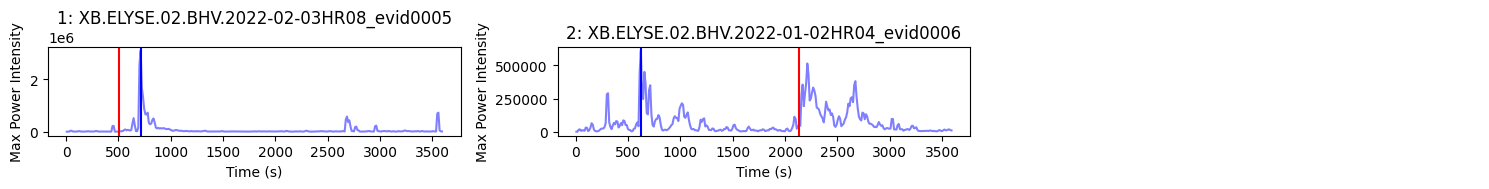

In [8]:
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(train_streams):
    sta_n, t  = sta_algo(stream)

    axs[i].plot(t, sta_n,  alpha=0.5, color="blue")
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].axvline(x=t[np.argmax(sta_n)], c="blue")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Max Power Intensity")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

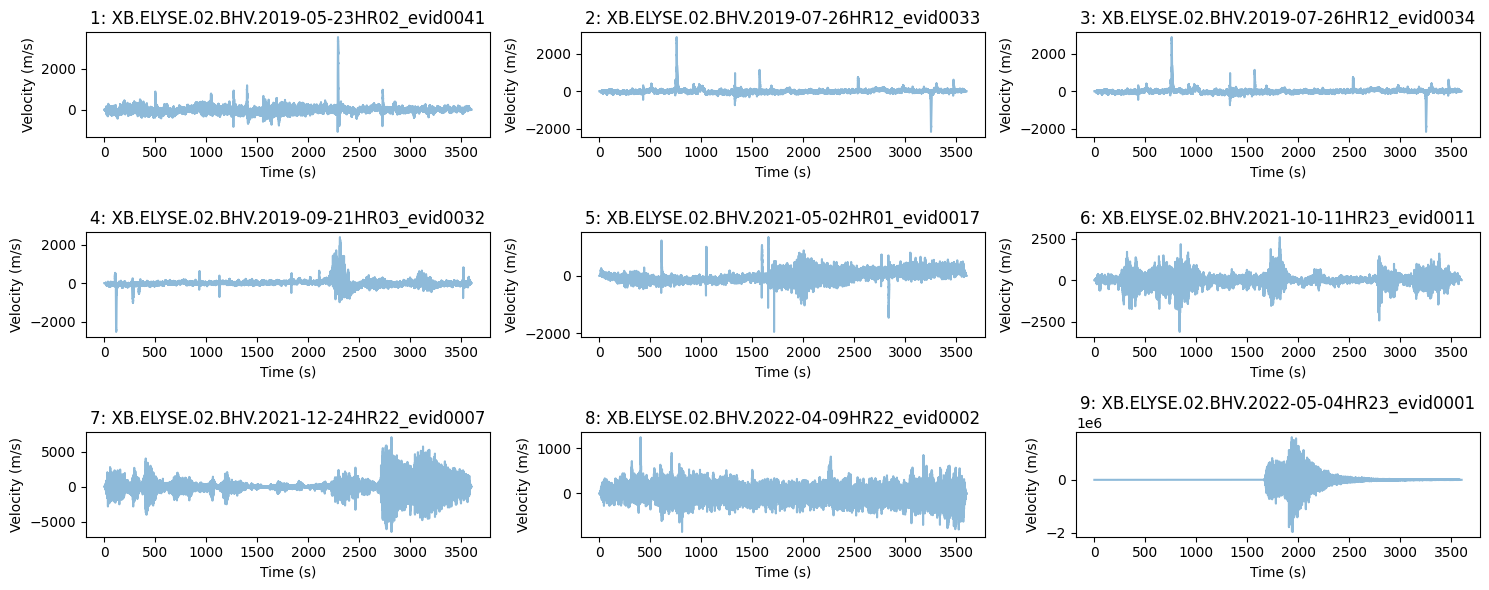

In [9]:
nrows = len(test_streams) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(test_streams):
    x, y = get_time_speed(stream)

    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

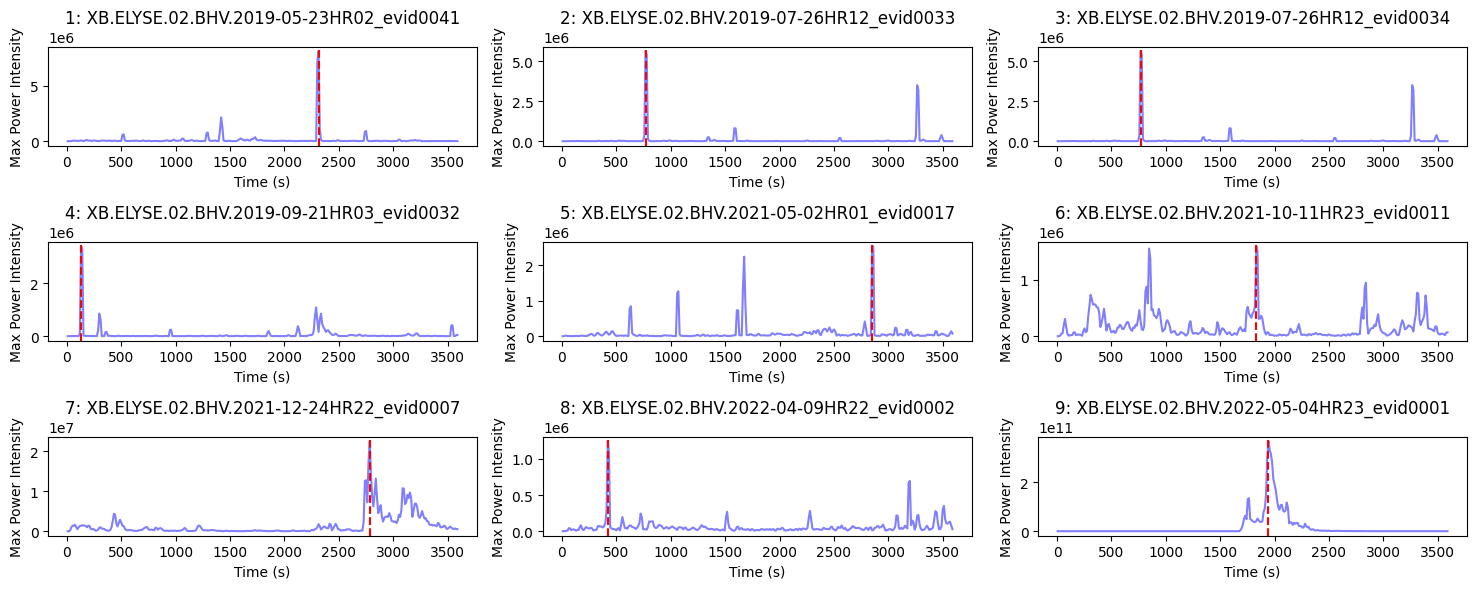

In [10]:
nrows = (len(test_streams) ) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(test_streams):
    sta_n, t  = sta_algo(stream)

    axs[i].plot(t, sta_n,  alpha=0.5, color="blue")
    axs[i].axvline(x=t[np.argmax(sta_n)], c="red", linestyle = "--")
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Max Power Intensity")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()